#**Importing Libraries**

In [53]:
import os
import kagglehub
import pandas as pd
import zipfile
import warnings
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [54]:
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#**1. Data collection - (Jay Dilipbhai Yadav)**


In [55]:
path = kagglehub.dataset_download("ramoliyafenil/text-based-cyber-threat-detection")
#print("Path to dataset files:", path)

if path.endswith(".zip"):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extract_path = os.path.splitext(path)[0]
        zip_ref.extractall(extract_path)
        path = extract_path
#print("Extracted dataset path:", path)

dataset_file = os.path.join(path,"cyber-threat-intelligence_all.csv")
data = pd.read_csv(dataset_file)
data.head()

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN


In [56]:
def sample_by_class(data, label_column, n_samples_per_class):
    sampled_data = pd.DataFrame()
    for class_label in data[label_column].unique():
        class_data = data[data[label_column] == class_label]
        sampled_class_data = class_data.sample(n=min(n_samples_per_class, len(class_data)))
        sampled_data = pd.concat([sampled_data, sampled_class_data], ignore_index=True)
    return sampled_data


sampled_data = sample_by_class(data, 'label', 2500)
sampled_data

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,5491,3277.0,OpenFFmpegLive The malware downloads FFmpeg f...,"[{'id': 48374, 'label': 'malware', 'start_offs...",[],[],48374.0,malware,0.0,14.0
1,1552,1569.0,"Bad Rabbit is a ransomware attack that, at th...","[{'id': 45059, 'label': 'malware', 'start_offs...","[{'id': 75, 'from_id': 45059, 'to_id': 45060, ...",[],45059.0,malware,1.0,11.0
2,4052,4078.0,HTShell hardcoded and encoded cookie string in...,"[{'id': 49914, 'label': 'malware', 'start_offs...",[],[],49914.0,malware,94.0,101.0
3,4244,5262.0,What does AnubisSpy mean to the mobile landscape?,"[{'id': 16180, 'label': 'malware', 'start_offs...",[],[],16180.0,malware,10.0,19.0
4,5357,911.0,It should be noted that PClock takes a very lo...,"[{'id': 46433, 'label': 'malware', 'start_offs...",[],[],46433.0,malware,24.0,30.0
...,...,...,...,...,...,...,...,...,...,...
9933,3433,NaN,aos.exe BIOPASS RAT binary (PyInstaller) Tro...,NaN,NaN,NaN,NaN,hash,NaN,NaN
9934,4264,NaN,"Interestingly, one of those keys, “xldbszcd”, ...",NaN,NaN,NaN,NaN,hash,NaN,NaN
9935,3977,NaN,Indicators of compromise Filename Path SHA-...,NaN,NaN,NaN,NaN,hash,NaN,NaN
9936,207,NaN,"On Feb. 23, a malicious file named conhosts._e...",NaN,NaN,NaN,NaN,hash,NaN,NaN


In [57]:
data=sampled_data.copy()

#**2. Data Cleaning-(Jay Dilipbhai Yadav)**

In [58]:
#check for missing values in all the columns
print(data.isna().sum())


Unnamed: 0        0
index           476
text              0
entities        476
relations       476
Comments        476
id              476
label             0
start_offset    476
end_offset      476
dtype: int64


In [59]:
# Drop rows with any null values
data.dropna(inplace=True)

In [60]:
print(data.isna().sum())

Unnamed: 0      0
index           0
text            0
entities        0
relations       0
Comments        0
id              0
label           0
start_offset    0
end_offset      0
dtype: int64


In [61]:
#only get text and label column from all data
data=data[["text","label"]]
data.head()

,text,label
0,OpenFFmpegLive The malware downloads FFmpeg f...,malware
1,"Bad Rabbit is a ransomware attack that, at th...",malware
2,HTShell hardcoded and encoded cookie string in...,malware
3,What does AnubisSpy mean to the mobile landscape?,malware
4,It should be noted that PClock takes a very lo...,malware


In [62]:
def preprocess_text(text_column):
    """
    preprocessing the text column
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    def clean_text(text):
        # lowercase conversion
        text = text.lower()
        # remove special characters, numbers
        text = re.sub(r'[^a-z\s]', '', text)
        # remove stopwords and lemmatize words
        text = ' '.join(
            lemmatizer.lemmatize(word)
            for word in text.split()
            if word not in stop_words
        )
        return text

    return text_column.apply(clean_text)

In [63]:
# apply preprocessing
data['clean_text'] = preprocess_text(data['text'])
text_col_index = data.columns.get_loc('text')
data.insert(text_col_index + 1, 'clean_text', data.pop('clean_text'))
data.head()

,text,clean_text,label
0,OpenFFmpegLive The malware downloads FFmpeg f...,openffmpeglive malware downloads ffmpeg file f...,malware
1,"Bad Rabbit is a ransomware attack that, at th...",bad rabbit ransomware attack time writing appe...,malware
2,HTShell hardcoded and encoded cookie string in...,htshell hardcoded encoded cookie string reques...,malware
3,What does AnubisSpy mean to the mobile landscape?,anubisspy mean mobile landscape,malware
4,It should be noted that PClock takes a very lo...,noted pclock take long time encrypt file,malware


#**3.Exploratory Data Analysis-(Harshkumar Dharmendrabhai Patel)**

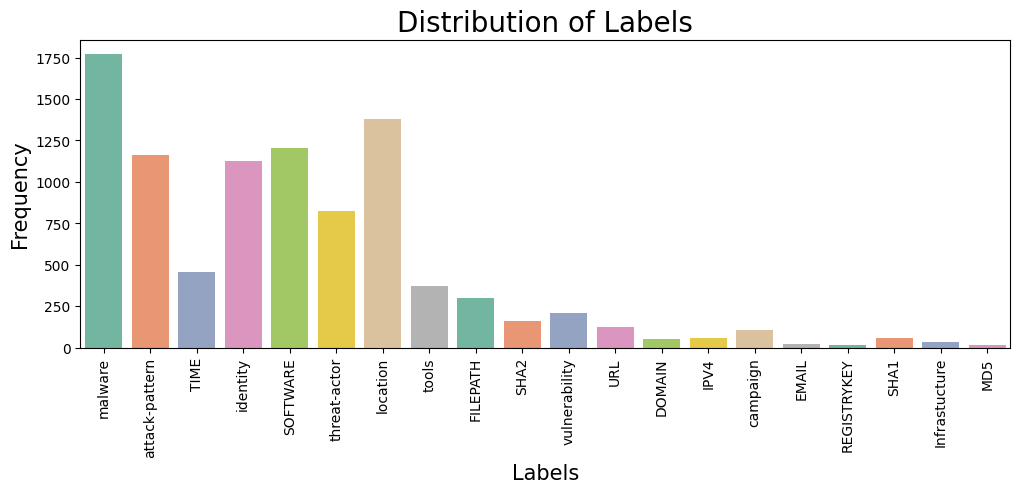

In [64]:
# countplot for label distribution
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='label', palette='Set2')
plt.title('Distribution of Labels',size=20)
plt.xlabel('Labels',size=15)
plt.ylabel('Frequency',size=15)
plt.xticks(rotation=90)
plt.show()

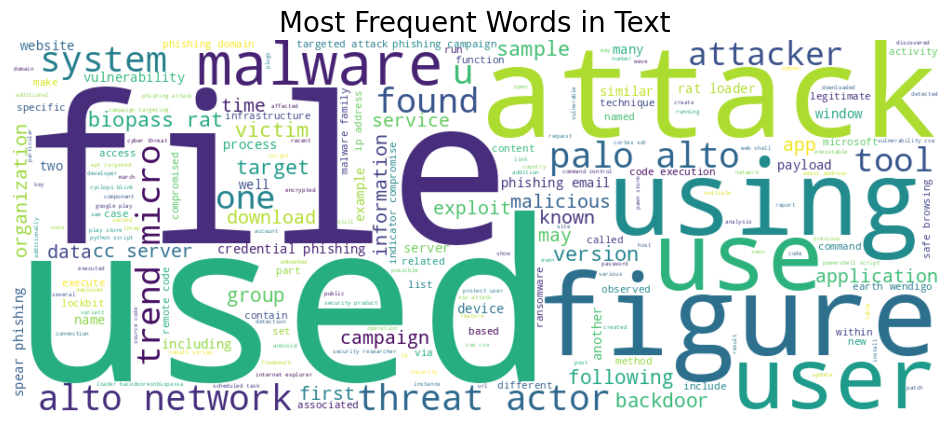

In [65]:
# combine all clean_text into a single string
all_text = ' '.join(data['clean_text'])
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Text',size=20)
plt.show()

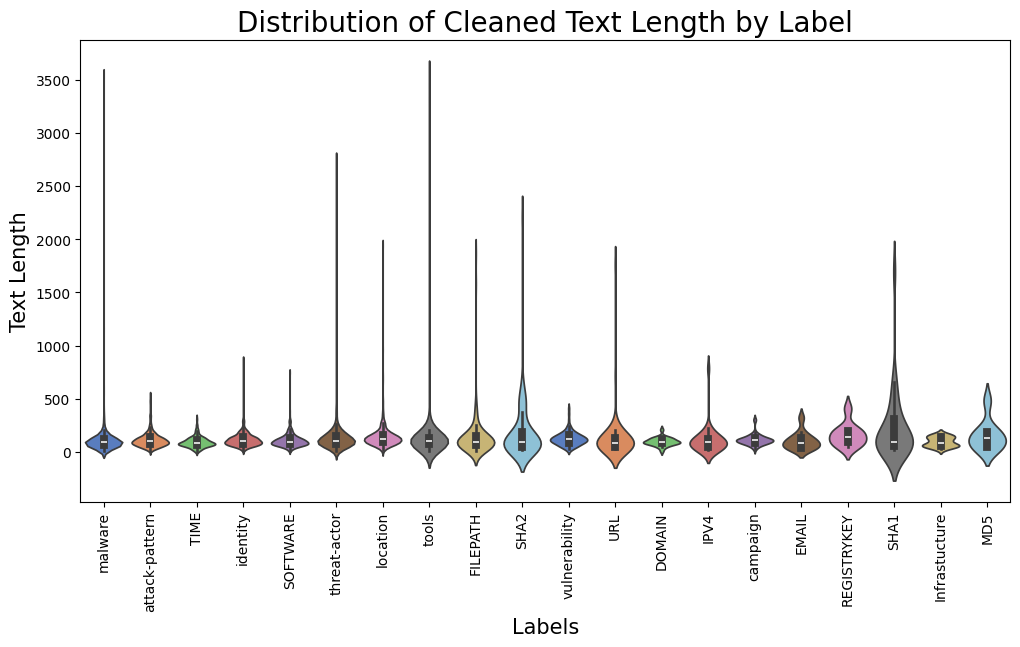

In [66]:
# calculate text length
data['clean_text_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(12, 6))
sns.violinplot(data=data, x='label', y='clean_text_length', palette='muted')
plt.title('Distribution of Cleaned Text Length by Label',size=20)
plt.xlabel('Labels',size=15)
plt.ylabel('Text Length',size=15)
plt.xticks(rotation=90)
plt.show()

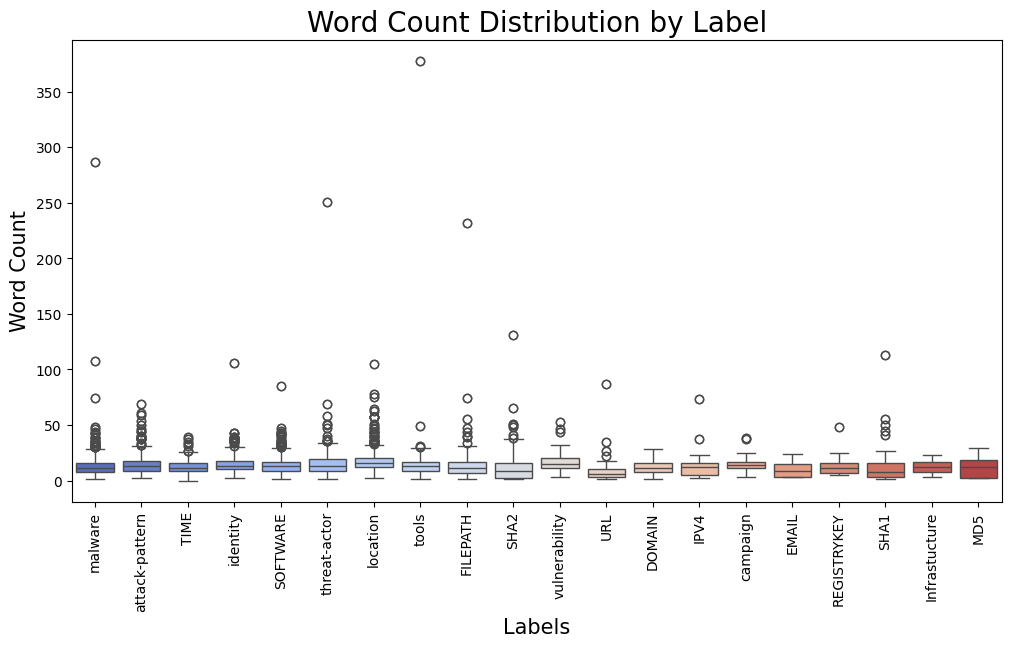

In [67]:
# calculate word count
data['word_count'] = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='label', y='word_count', palette='coolwarm')
plt.title('Word Count Distribution by Label',size=20)
plt.xlabel('Labels',size=15)
plt.ylabel('Word Count',size=15)
plt.xticks(rotation=90)
plt.show()

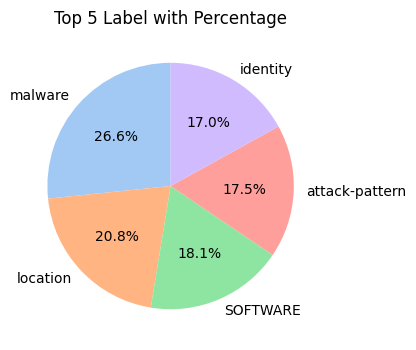

In [68]:
# top 5 labels by their frequency
top_labels = data['label'].value_counts().nlargest(5)
plt.figure(figsize=(8, 4))
top_labels.plot.pie(autopct='%1.1f%%',startangle=90,colors=sns.color_palette("pastel"))
plt.title('Top 5 Label with Percentage')
plt.axis("off")
plt.show()

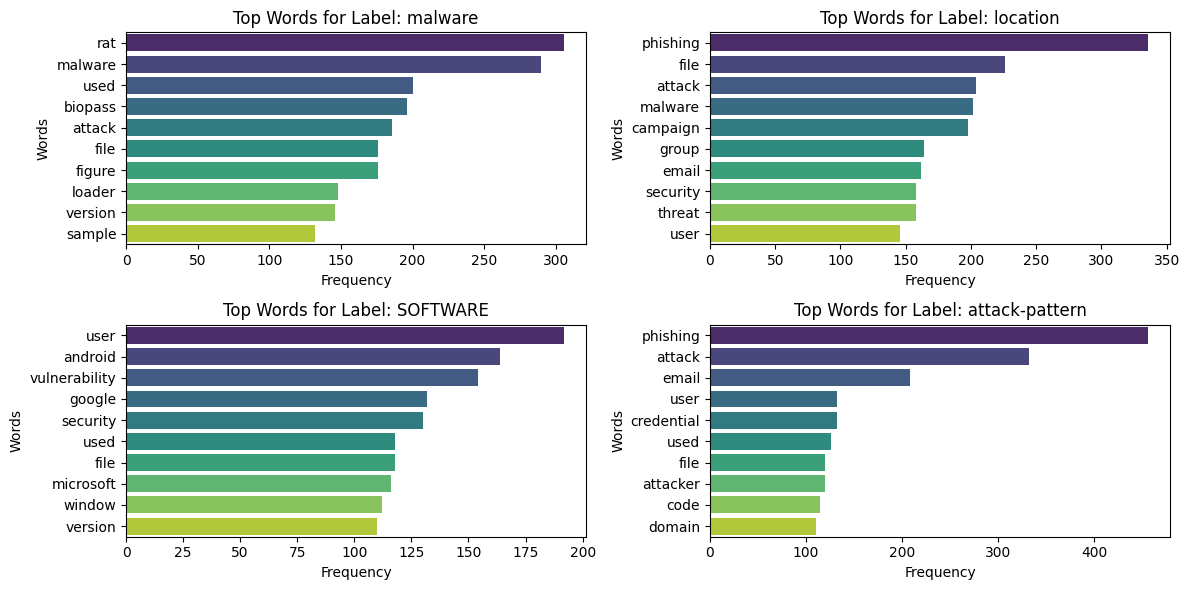

In [69]:
# top 4 labels by frequency
top_labels = data['label'].value_counts().nlargest(4).index
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
for i, label in enumerate(top_labels):
    label_text = ' '.join(data[data['label'] == label]['clean_text'])
    common_words = Counter(label_text.split()).most_common(10)
    words, counts = zip(*common_words)

    sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
    axes[i].set_title(f'Top Words for Label: {label}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Words')
plt.tight_layout()
plt.show()

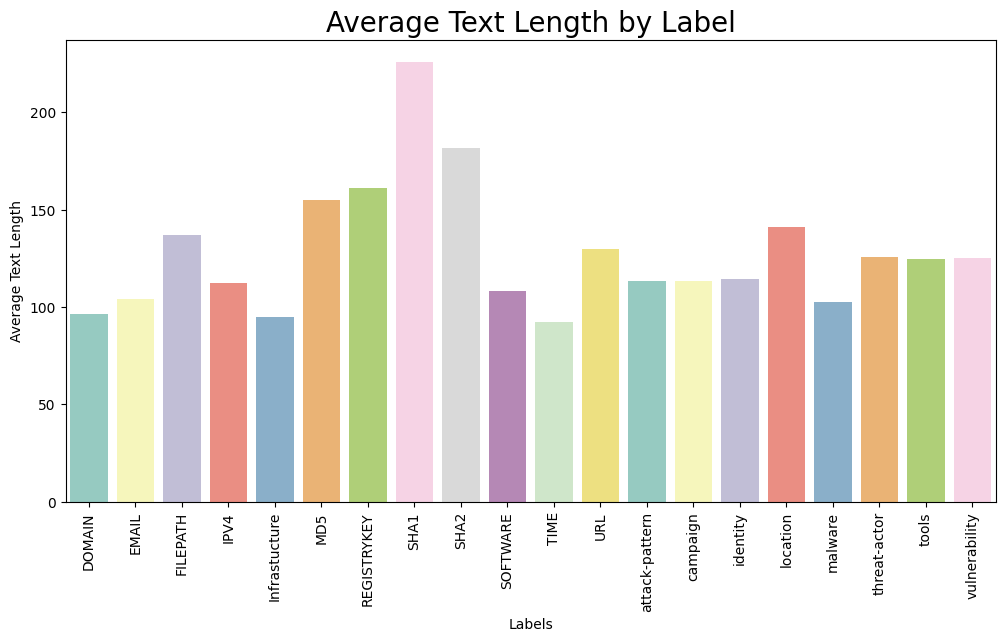

In [70]:
# average text length by label
avg_length = data.groupby('label')['clean_text_length'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_length, x='label', y='clean_text_length', palette='Set3')
plt.title('Average Text Length by Label',size=20)
plt.xlabel('Labels')
plt.ylabel('Average Text Length')
plt.xticks(rotation=90)
plt.show()

#**4.Feature Engineering-(Sonam Peldenav)**

In [71]:
# vectorize clean_text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
x = vectorizer.fit_transform(data['clean_text']).toarray()

# encode labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

#**5.Train-Test Split - (Harshkumar Dharmendrabhai Patel)**

In [72]:
#data split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#**6.Model Building-(Sonam Pelden)**


In [73]:

# Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Logistic Regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# ANN model
model = Sequential()
# Input Layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
# Output Layer
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
# Compile and Train
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
237/237 - 5s - 21ms/step - accuracy: 0.2325 - loss: 2.3246 - val_accuracy: 0.4670 - val_loss: 1.8145
Epoch 2/10
237/237 - 2s - 9ms/step - accuracy: 0.5706 - loss: 1.4109 - val_accuracy: 0.6661 - val_loss: 1.1689
Epoch 3/10
237/237 - 3s - 11ms/step - accuracy: 0.7535 - loss: 0.8361 - val_accuracy: 0.7575 - val_loss: 0.9208
Epoch 4/10
237/237 - 2s - 10ms/step - accuracy: 0.8430 - loss: 0.5689 - val_accuracy: 0.7987 - val_loss: 0.8129
Epoch 5/10
237/237 - 3s - 11ms/step - accuracy: 0.8907 - loss: 0.4108 - val_accuracy: 0.8336 - val_loss: 0.7492
Epoch 6/10
237/237 - 4s - 15ms/step - accuracy: 0.9094 - loss: 0.3263 - val_accuracy: 0.8426 - val_loss: 0.7367
Epoch 7/10
237/237 - 4s - 16ms/step - accuracy: 0.9243 - loss: 0.2713 - val_accuracy: 0.8510 - val_loss: 0.7679
Epoch 8/10
237/237 - 2s - 10ms/step - accuracy: 0.9351 - loss: 0.2324 - val_accuracy: 0.8616 - val_loss: 0.7266
Epoch 9/10
237/237 - 2s - 10ms/step - accuracy: 0.9363 - loss: 0.2117 - val_accuracy: 0.8716 - val_loss: 

#**7.Model Evaluation-(Walgama Ranasinghe Arachchilage)**

In [74]:

# ANN evaluation
y_pred_ann_probs = model.predict(X_test)
y_pred_ann = np.argmax(y_pred_ann_probs, axis=1)
print("ANN Classification Report:")
print(classification_report(y_test, y_pred_ann, target_names=label_encoder.classes_))
print(f"ANN Accuracy: {accuracy_score(y_test, y_pred_ann):.4f}")

# Random Forest evaluation
random_forest_pred = random_forest_model.predict(X_test)
random_forest_probs = random_forest_model.predict_proba(X_test)[:, 1]  # For binary AUC calculation
print("Random Forest Classification Report:")
print(classification_report(y_test, random_forest_pred, target_names=label_encoder.classes_))
print(f"Random Forest Accuracy: {accuracy_score(y_test, random_forest_pred):.4f}")

# SVM evaluation
svm_pred = svm_model.predict(X_test)
svm_probs = svm_model.predict_proba(X_test)[:, 1]  # For binary AUC calculation
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=label_encoder.classes_))
print(f"SVM Accuracy: {accuracy_score(y_test, svm_pred):.4f}")

# Logistic Regression evaluation
log_pred = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]  # For binary AUC calculation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_pred, target_names=label_encoder.classes_))
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_pred):.4f}")



60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
ANN Classification Report:
                precision    recall  f1-score   support

        DOMAIN       0.60      0.50      0.55        12
         EMAIL       0.50      0.50      0.50         4
      FILEPATH       0.89      0.85      0.87        66
          IPV4       0.79      1.00      0.88        11
 Infrastucture       1.00      0.75      0.86         8
           MD5       0.00      0.00      0.00         4
   REGISTRYKEY       1.00      1.00      1.00         4
          SHA1       1.00      1.00      1.00        13
          SHA2       0.66      0.82      0.73        38
      SOFTWARE       0.86      0.90      0.88       239
          TIME       0.92      0.81      0.86        97
           URL       0.89      0.80      0.84        20
attack-pattern       0.85      0.88      0.87       221
      campaign       0.68      0.83      0.75        23
      identity       0.87      0.82      0.85       238
      location       0.84      0.86  

#**8.Model Comparision - (Walgama Ranasinghe Arachchilage**


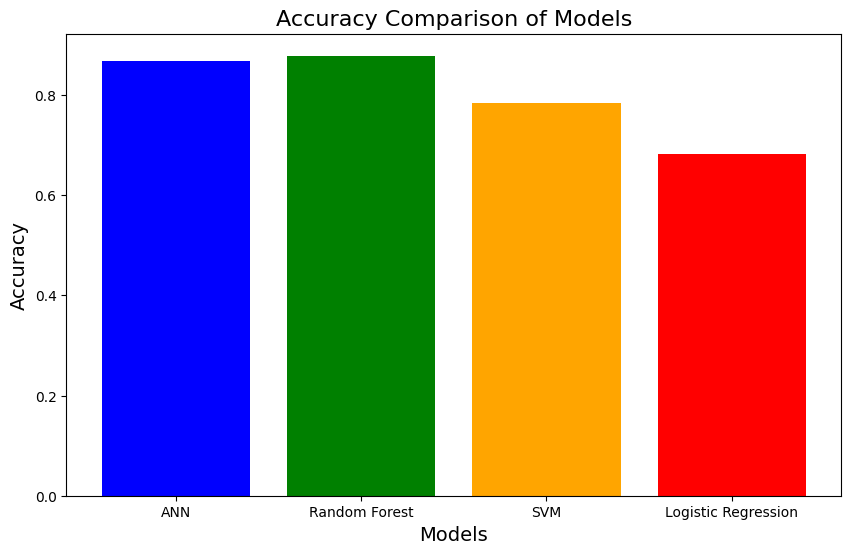

In [75]:
# Accuracy comparison
model_names = ['ANN', 'Random Forest', 'SVM', 'Logistic Regression']
accuracies = [
    accuracy_score(y_test, y_pred_ann),
    accuracy_score(y_test, random_forest_pred),
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, log_pred)
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title("Accuracy Comparison of Models", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Models", fontsize=14)
plt.show()

#**9.Model Deployment - (Jay Dilipbhai Yadav)**

In [76]:
best_model = random_forest_model
pickle_filename = "best_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {pickle_filename}.")

Best model saved as best_model.pkl.
